Looking at the August 2016 renewal in nowcast-green, nowcast and obs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import datetime
from dateutil import tz
import os
import pandas as pd

from salishsea_tools import (
    geo_tools,
    places,
    psu_tools,
    teos_tools,
    data_tools,
    tidetools,
)

from nowcast import analyze
from nowcast.figures import shared

%matplotlib inline

In [2]:
runs={}
t_o=datetime.datetime(2016,8,1); t_f = datetime.datetime(2016,9,6)
fnames = analyze.get_filenames(t_o, t_f, '1d', 'grid_T', '/results/SalishSea/nowcast-green/')
grid_B=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_downbyone2.nc')

runs = {'nowcast-green': {'grid': grid_B,
                          'mesh': mesh_mask,
                          'fnames': fnames,
                          'nemo36': True}}

In [3]:
fnames = analyze.get_filenames(t_o, t_f, '1d', 'grid_T', '/results/SalishSea/nowcast/')
grid_B=nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

runs['nowcast']= {'grid': grid_B,
                  'mesh': mesh_mask,
                  'fnames': fnames,
                  'nemo36': False}

In [4]:
def get_onc_TS_time_series(station, t_o, t_f):
    """Grab the ONC temperature and salinity time series for a station between dates
    t_o and t_f. Return results as separate temperature and salinty data frames."""
    numdays = (t_f-t_o).days
    dates = [t_o + datetime.timedelta(days=num)
             for num in range(0, numdays+1)]
    sal_pd = pd.DataFrame({'time':[],
                           'data': []})
    temp_pd = pd.DataFrame({'time': [],
                            'data': []})
    station_code = places.PLACES[station]['ONC stationCode']
    for date in dates:
        onc_data = data_tools.get_onc_data(
            'scalardata', 'getByStation', os.environ['ONC_USER_TOKEN'],
            station=station_code,
            deviceCategory='CTD', sensors='salinity,temperature',
            dateFrom=data_tools.onc_datetime(date, 'utc'))
        try:
            ctd_data=data_tools.onc_json_to_dataset(onc_data, teos=False) #keep in PSU!
            #quality control
            qc_sal = np.array(ctd_data.salinity.qaqcFlag)
            qc_temp = np.array(ctd_data.temperature.qaqcFlag)
            #average 
            sal_pd = sal_pd.append({'time': ctd_data.salinity.sampleTime.values[0],
                                    'data': ctd_data.salinity.values[qc_sal==1].mean()}, 
                                    ignore_index=True)
            temp_pd = temp_pd.append({'time': ctd_data.temperature.sampleTime.values[0],
                                      'data': ctd_data.temperature.values[qc_temp==1].mean()}, 
                                      ignore_index=True)
        except TypeError:
            print('No data for {} at {}'.format(date, station))
    return sal_pd, temp_pd

In [5]:
def get_model_time_series(station, fnames, grid_B, mesh_mask, nemo_36=True):
    """Retrieve the density, salinity and temperature time series at a station. 
    Time series is created from files listed in fnames"""
    if nemo_36:
        depth_var='gdept_0'
        depth_var_w = 'gdepw_0'
    else:
        depth_var='gdept'
        depth_var_w = 'gdepw'
    
    #station info
    lon = places.PLACES[station]['lon lat'][0]
    lat = places.PLACES[station]['lon lat'][1]
    depth = places.PLACES[station]['depth']
    
    # model corresponding locations and variables
    bathy, X, Y = tidetools.get_bathy_data(grid_B)
    j, i = geo_tools.find_closest_model_point(lon,lat,X,Y, land_mask=bathy.mask)
    model_depths = mesh_mask.variables[depth_var][0,:,j,i]
    tmask = mesh_mask.variables['tmask'][0,:,j,i]
    wdeps = mesh_mask.variables[depth_var_w][0,:,j,i]
    sal, time = analyze.combine_files(fnames,'vosaline','None',j,i)
    temp, time = analyze.combine_files(fnames,'votemper','None',j,i)
    
    # interpolate:
    sal_interp=np.array(
        [shared.interpolate_tracer_to_depths(
            sal[i,:],model_depths,depth,tmask,wdeps)
        for i in range(sal.shape[0])])
    temp_interp=np.array(
        [shared.interpolate_tracer_to_depths(
            temp[i,:],model_depths,depth,tmask,wdeps)
        for i in range(temp.shape[0])])
    
    # convert to psu for using density function
    if nemo_36:
        sal_interp = teos_tools.teos_psu(sal_interp)
    density = psu_tools.calculate_density(temp_interp, sal_interp)
    
    return density, sal_interp, temp_interp, time

In [6]:
rhos = {'nowcast': {}, 'nowcast-green': {}}
times = {'nowcast': {}, 'nowcast-green': {}}
sals={'nowcast': {}, 'nowcast-green': {}}
temps={'nowcast': {}, 'nowcast-green': {}}
stations = ['Central node', 'East node', 'Delta BBL node', 'Delta DDL node']
for sim in ['nowcast', 'nowcast-green']:
    print(sim)
    for station in stations:
        print(station)
        rhos[sim][station], sals[sim][station], temps[sim][station], times[sim][station] = \
            get_model_time_series(station, runs[sim]['fnames'], runs[sim]['grid'],
                                  runs[sim]['mesh'], nemo_36=runs[sim]['nemo36'] )

nowcast
Central node
East node
Delta BBL node
Delta DDL node
nowcast-green
Central node
East node
Delta BBL node
Delta DDL node


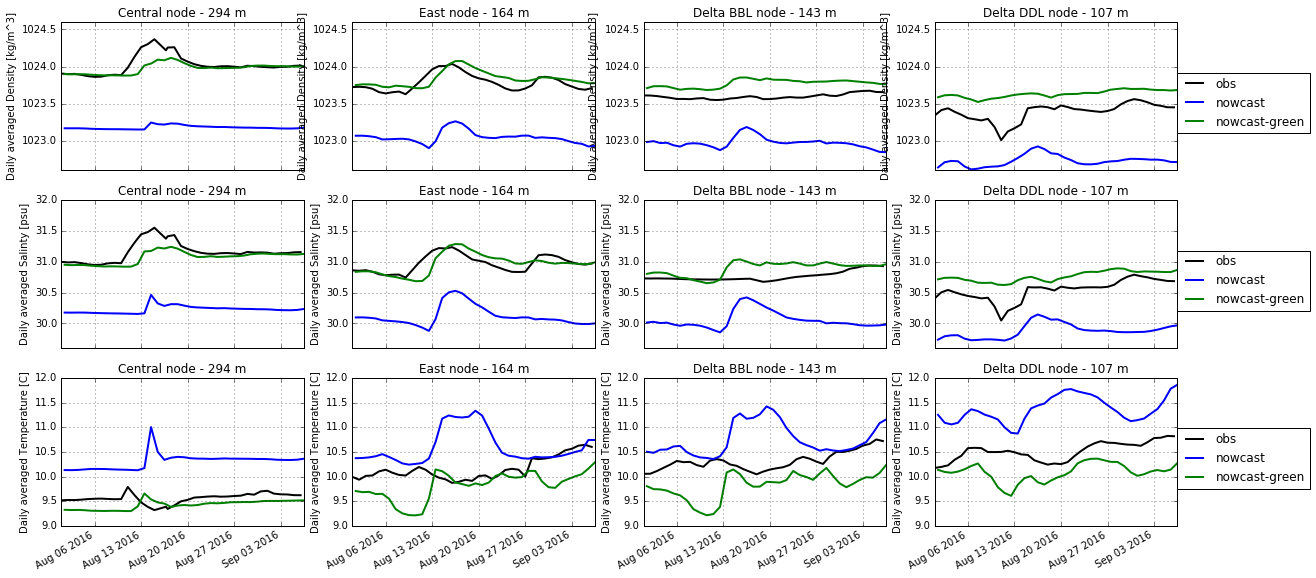

In [7]:
fig, axs = plt.subplots(3,4,figsize=(20,10), sharex=True)
names = ['Density [kg/m^3]', 'Salinty [psu]', 'Temperature [C]']
titles = ['density', 'salinity', 'temperature']
ticks = [[1022.6,1024.6], [29.6, 32], [9,12]]
cols = ['b', 'g']
for i, station in enumerate(stations):
    axc = axs[:,i]
    obs_sal, obs_temp = get_onc_TS_time_series(station, t_o, t_f)
    obs_rho = pd.DataFrame({'time':[], 'data':[]})
    obs_rho.data = psu_tools.calculate_density(obs_temp['data'].values, obs_sal['data'].values )
    obs_rho.time = obs_temp.time
    obs = [obs_rho, obs_sal,obs_temp]
    for sim, col in zip(['nowcast', 'nowcast-green'], cols):
        variables = [rhos[sim], sals[sim], temps[sim]]
        t = times[sim]
        for var, name, title, ax, ob, tick in zip(variables, names, titles, axc, obs,ticks):
            if sim == 'nowcast': #only plot obs once
                ax.plot(ob.time, ob.data, 'k', label='obs'.format(station), lw=2)
            ax.plot(np.array(t[station]), np.array(var[station]), c=col, label=sim, lw=2)
            ax.set_ylabel('Daily averaged {}'.format(name))
            ax.set_title('{} - {} m'.format(station, places.PLACES[station]['depth']))
            ax.set_ylim(tick)
for ax in axs.flatten():
    ax.grid()
    ax.get_yaxis().get_major_formatter().set_useOffset(False)
for ax in axs[:,-1]:
    ax.legend(loc=(1,0.25))
fig.autofmt_xdate()